Part 1: Package Installation and Imports
In this section, we begin by ensuring that all the necessary libraries and dependencies are installed and available to the environment. Using pip commands, we install packages such as Pandas, NumPy, Librosa, Scikit-Learn, Matplotlib, Seaborn, Plotly, and MLJAR-Scikit-Plot. These libraries are essential for data manipulation, audio feature extraction, machine learning modeling, and visualization.
Once installed, the code imports these modules, which sets up a clean workspace with all the tools required for subsequent stages. This section is intended to be run as the first cell in your notebook, guaranteeing that every part of your project has access to the needed functionalities and preventing issues related to missing dependencies.

In [ ]:
# ------------------------------
# Part 1: Package Installation and Imports
# ------------------------------
# Install essential libraries:
!pip install pandas numpy librosa scikit-learn matplotlib seaborn plotly mljar-scikit-plot

# Importing required libraries for data handling, feature extraction, modeling, and visualization.
import pandas as pd
import numpy as np
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


  Preparing metadata (setup.py) ... done
  Created wheel for mljar-scikit-plot: filename=mljar_scikit_plot-0.3.12-py3-none-any.whl size=32014 sha256=daaf1ebf3edbeb9c82f1148292316a77054135cfc30df2f0b8252720860e95bb
  Stored in directory: /root/.cache/pip/wheels/e2/2d/3e/8afe0632e7b03c3ae7b8048f88f0dcca4355b32d31abaea3ba
Successfully built mljar-scikit-plot


Part 2: Data Loading and Preprocessing
The second part of the project focuses on reading the raw dataset into the workspace. The code addresses potential delimiter issues (e.g., differences between comma, semicolon, or tab-separated files) using sequential attempts with error handling, guaranteeing that the file is correctly read.
After loading the dataset, the code tackles data quality issues: it checks for and drops missing values to ensure clean data and then normalizes numerical audio feature columns (such as tempo, loudness, valence, danceability, energy, and acousticness) using a MinMaxScaler. An optional step is included for extracting additional audio features from audio files through Librosa, if the dataset includes file paths. Finally, the processed dataset is saved to a new CSV file so that future steps (like EDA and modeling) can reuse the cleaned data without repeating preprocessing.

In [ ]:
# ------------------------------
# Part 2: Data Loading and Preprocessing
# ------------------------------

# Update this file path with the location of your dataset.
file_path = "/content/dataset.csv"  # Change this path if needed

# Attempt to read the CSV file using commas, then semicolons, and finally tabs as delimiters.
try:
    # Try reading CSV with a comma as a delimiter.
    df = pd.read_csv(file_path, sep=',', quotechar='"', on_bad_lines='skip')
except pd.errors.ParserError:
    try:
        # If failed, try reading CSV with a semicolon as a delimiter.
        df = pd.read_csv(file_path, sep=';', quotechar='"', on_bad_lines='skip')
    except pd.errors.ParserError:
        # Lastly, try reading the CSV with a tab delimiter.
        df = pd.read_csv(file_path, sep='\t', quotechar='"', on_bad_lines='skip')

# Print missing values count per column.
print("\nMissing Values:")
print(df.isnull().sum())

# Drop rows (or columns) with missing values if necessary.
df.dropna(inplace=True)

# Define the list of relevant audio features.
audio_features = ['tempo', 'loudness', 'valence', 'danceability', 'energy', 'acousticness']

# Normalize the numerical audio features using MinMaxScaler for consistency.
scaler = MinMaxScaler()
df[audio_features] = scaler.fit_transform(df[audio_features])

# Display descriptive statistics of normalized features.
print("\nData after Normalization:")
print(df[audio_features].describe())

# ------------------------------
# Optionally, extract additional audio features using Librosa.
# This is useful if your dataset contains a 'file_path' column pointing to audio files.
# ------------------------------
def extract_audio_features(file_path_audio):
    """
    Extracts basic audio features from an audio file.

    Parameters:
      file_path_audio (str): Path to the audio file.

    Returns:
      dict: A dictionary containing the mean MFCC, chroma_stft, spectral contrast, and zero crossing rate.
    """
    y, sr = librosa.load(file_path_audio, sr=None)  # Load audio file with its native sampling rate.
    features = {
        "mfcc_mean": np.mean(librosa.feature.mfcc(y=y, sr=sr).T, axis=0),
        "chroma_stft_mean": np.mean(librosa.feature.chroma_stft(y=y, sr=sr)),
        "spectral_contrast_mean": np.mean(librosa.feature.spectral_contrast(y=y, sr=sr)),
        "zero_crossing_rate": np.mean(librosa.feature.zero_crossing_rate(y))
    }
    return features

# If your dataset includes a column called 'file_path':
if 'file_path' in df.columns:
    # Apply feature extraction for each audio file.
    audio_features_list = df['file_path'].apply(extract_audio_features)
    extracted_features_df = pd.DataFrame(audio_features_list.tolist())
    # Merge the new features with the main dataset.
    df = pd.concat([df, extracted_features_df], axis=1)

# Display the shape of the processed dataset.
print("\nProcessed Dataset Shape:", df.shape)

# Save the cleaned and processed dataset to a new CSV file.
processed_file_path = "/content/dataset - Copy.csv"  # Update path if needed
df.to_csv(processed_file_path, index=False)
print("\n✅ Data Preprocessing & Feature Extraction Completed!")



Missing Values:
Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         1
dtype: int64

Data after Normalization:
              tempo      loudness       valence  danceability        energy  \
count  77909.000000  77909.000000  77909.000000  77909.000000  77909.000000   
mean       0.503952      0.728891      0.458641      0.573487      0.653358   
std        0.121496      0.106096      0.256366      0.179738      0.252015   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.410832      0.691021      0.244221      0.456301      0.485990   
50%    

Part 3: Exploratory Data Analysis (EDA)
This section is dedicated to understanding the data. First, the preprocessed dataset is loaded, and a comprehensive overview of its structure and quality is printed (i.e., basic information, summary statistics, and checks for missing values).
After understanding the dataset at a high level, various visualizations are produced to explore the data in depth. These include:
Histograms and KDE plots to analyze the distribution of numeric features.
A correlation heatmap to observe pairwise relationships among the features and detect potentially redundant information.

Pair plots that visually compare the relationships between selected features.

Boxplots that help to identify outliers which might affect model performance.

If a "mood" column exists, its distribution is visualized via bar and pie charts.
 Collectively, these visualizations provide insights into the data’s structure, variability, and potential challenges that may need to be addressed before modeling.

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77909 entries, 0 to 77908
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        77909 non-null  int64  
 1   track_id          77909 non-null  object 
 2   artists           77909 non-null  object 
 3   album_name        77909 non-null  object 
 4   track_name        77909 non-null  object 
 5   popularity        77909 non-null  int64  
 6   duration_ms       77909 non-null  int64  
 7   explicit          77909 non-null  bool   
 8   danceability      77909 non-null  float64
 9   energy            77909 non-null  float64
 10  key               77909 non-null  int64  
 11  loudness          77909 non-null  float64
 12  mode              77909 non-null  int64  
 13  speechiness       77909 non-null  float64
 14  acousticness      77909 non-null  float64
 15  instrumentalness  77909 non-null  float64
 16  liveness          77909 no

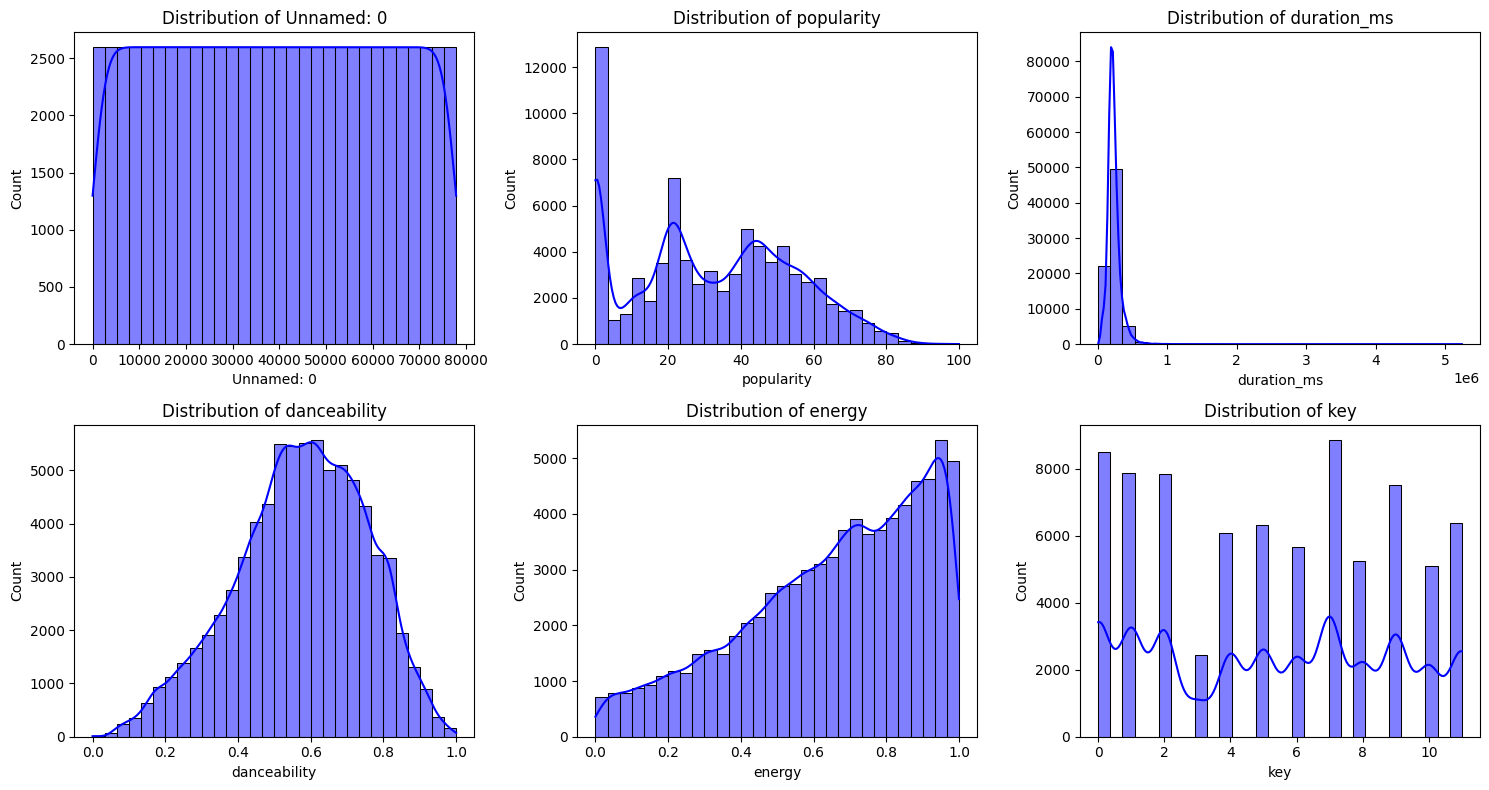

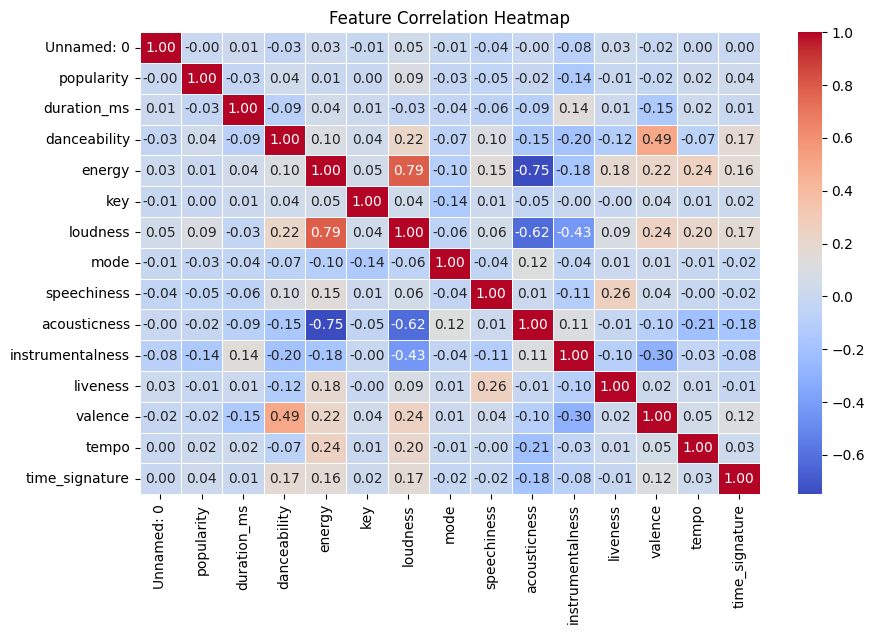

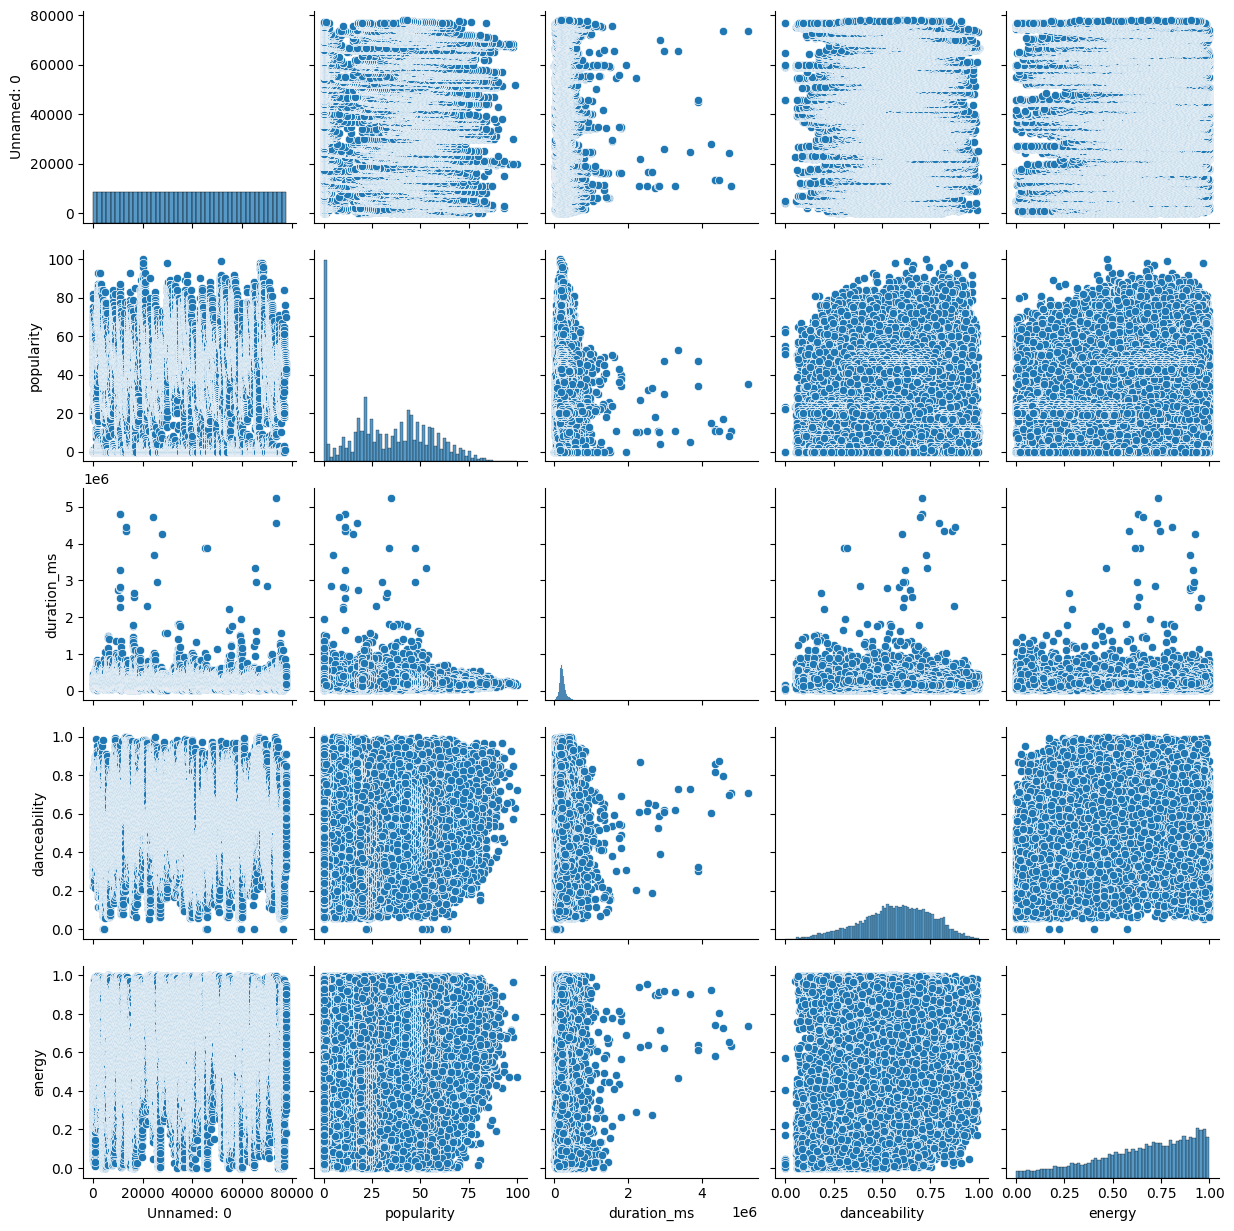

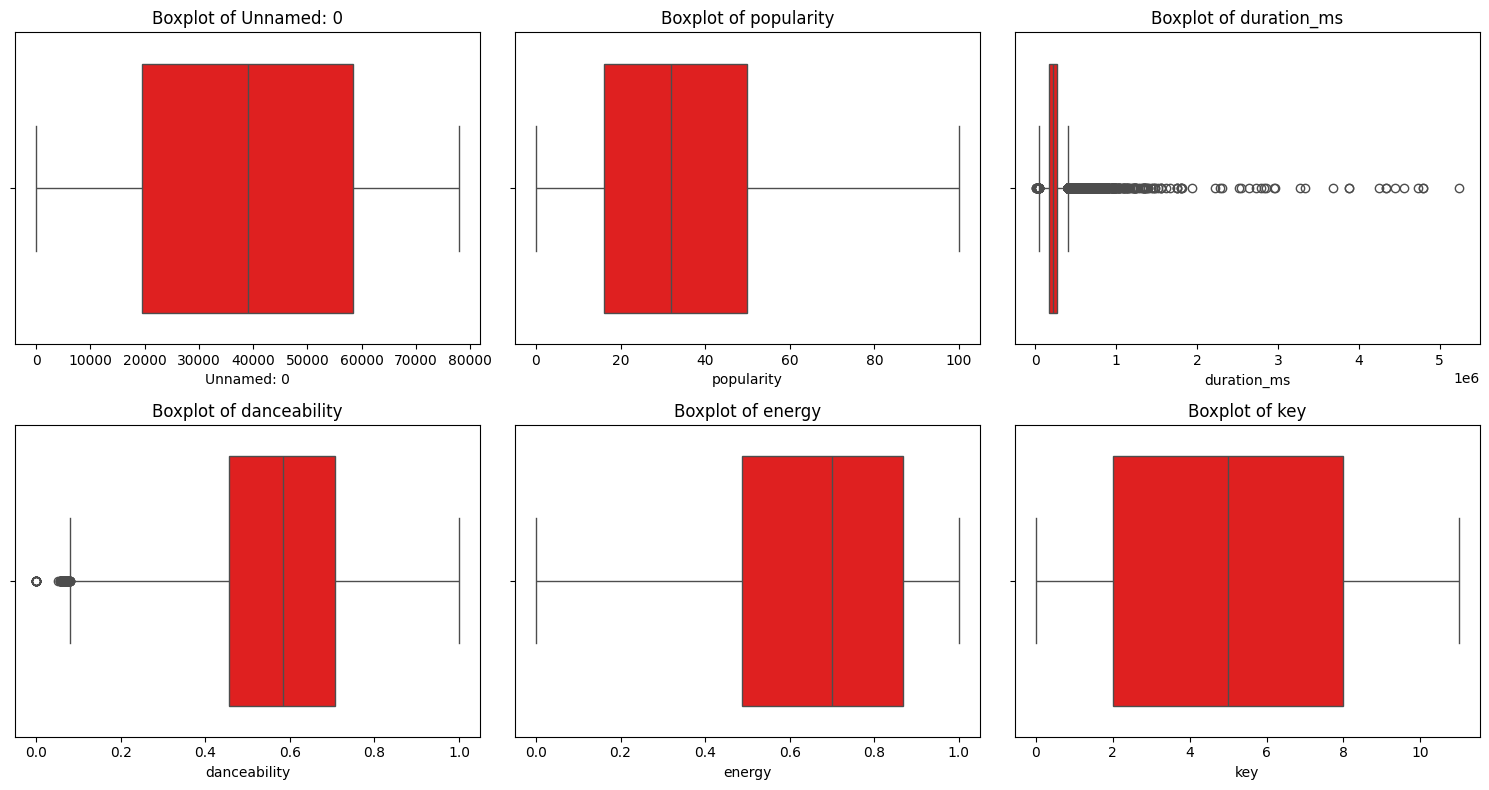


✅ EDA Completed!


In [ ]:
# ------------------------------
# Part 3: Exploratory Data Analysis (EDA)
# ------------------------------

# Load the preprocessed dataset that was saved in the previous part.
file_path_processed = "/content/dataset - Copy.csv"  # Update this path if necessary
df = pd.read_csv(file_path_processed)

# Basic dataset overview.
print("Dataset Info:")
print(df.info())

print("\nSummary Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

# ------------------------------
# Visualize distributions of numeric features.
# ------------------------------
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(15, 8))
# Plot a histogram with a KDE for each of the first six numeric features.
for i, col in enumerate(numeric_columns[:6]):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[col], bins=30, kde=True, color='blue')
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

# ------------------------------
# Correlation heatmap to understand pairwise relationships.
# ------------------------------
plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_columns].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# ------------------------------
# Pair plot to observe relationships among a few numeric features.
# ------------------------------
sns.pairplot(df[numeric_columns[:5]])
plt.show()

# ------------------------------
# Boxplots for outlier detection in the first six numeric columns.
# ------------------------------
plt.figure(figsize=(15, 8))
for i, col in enumerate(numeric_columns[:6]):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x=df[col], color='red')
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

# ------------------------------
# If the dataset contains a "mood" column, visualize its distribution.
# ------------------------------
if 'mood' in df.columns:
    plt.figure(figsize=(8, 5))
    df['mood'].value_counts().plot(kind='bar', color=['blue', 'orange', 'green', 'red'])
    plt.title("Mood Category Distribution")
    plt.xlabel("Mood")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(6, 6))
    df['mood'].value_counts().plot.pie(autopct='%1.1f%%', colors=['blue', 'orange', 'green', 'red'])
    plt.title("Mood Category Distribution")
    plt.ylabel("")
    plt.show()

print("\n✅ EDA Completed!")


Part 4: Model Implementation and Evaluation
In the final section, the cleaned and preprocessed data is used to build a supervised learning model—in this case, a mood classification model using a Random Forest classifier.
This part starts by defining the input feature set and the target variable. If a “mood” column isn't already present, it’s created using a heuristic based on the product of 'valence' and 'energy.' The target variable is then encoded into numeric values using a LabelEncoder. To reduce the dimensionality and focus on the most significant attributes, a feature selection step (SelectKBest) is applied.
Next, the data is split into training and testing portions. A baseline Random Forest model is trained using default hyperparameters; its performance is evaluated on the test set through accuracy, classification reports, and the visualization of confusion matrices.
To improve the model further, hyperparameter tuning is performed with GridSearchCV. This step involves searching across a predefined grid of parameters (such as the number of estimators, maximum depth, and minimum samples split) with cross-validation, to find the best model parameters. The best model’s performance is then evaluated and compared with the baseline model using various metrics and visualizations (including additional plots for accuracy and confusion matrix comparisons). This comprehensive evaluation helps to identify the optimal configuration for the classification task.
Each part of the project builds upon the previous one, from ensuring the environment is ready with proper dependencies through to a deep dive into the data, culminating in the implementation and refinement of a predictive model.

Selected features: ['loudness', 'valence', 'danceability', 'energy']

Baseline Model Accuracy: 99.80%

Baseline Classification Report:
              precision    recall  f1-score   support

       happy       1.00      1.00      1.00      1225
     neutral       1.00      1.00      1.00      5420
         sad       1.00      1.00      1.00      8934
         nan       1.00      1.00      1.00         3

    accuracy                           1.00     15582
   macro avg       1.00      1.00      1.00     15582
weighted avg       1.00      1.00      1.00     15582



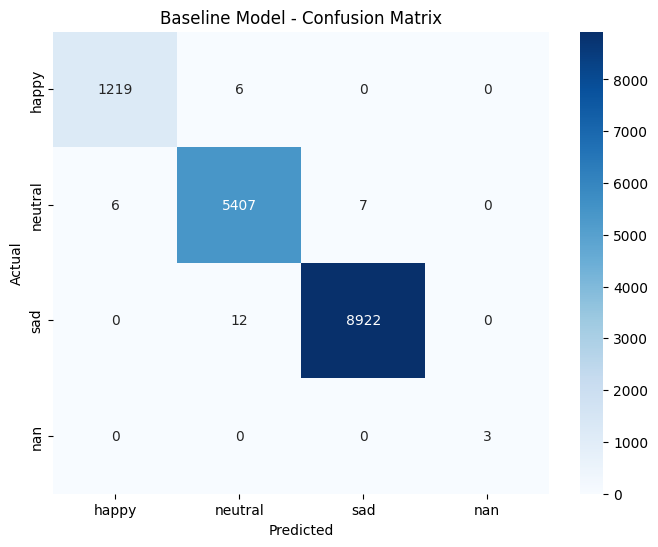

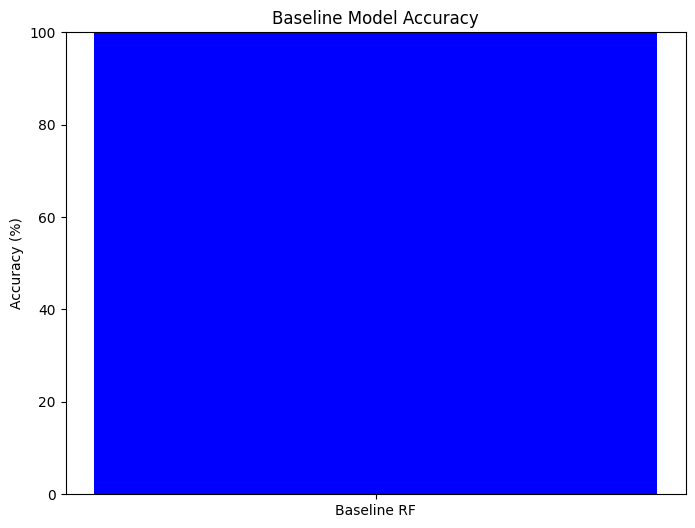

Best Hyperparameters from GridSearchCV:
{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best Cross-Validated Accuracy: 99.71%

Best Model Test Accuracy: 99.81%

Best Model Classification Report:
              precision    recall  f1-score   support

       happy       1.00      0.99      1.00      1225
     neutral       1.00      1.00      1.00      5420
         sad       1.00      1.00      1.00      8934
         nan       1.00      1.00      1.00         3

    accuracy                           1.00     15582
   macro avg       1.00      1.00      1.00     15582
weighted avg       1.00      1.00      1.00     15582



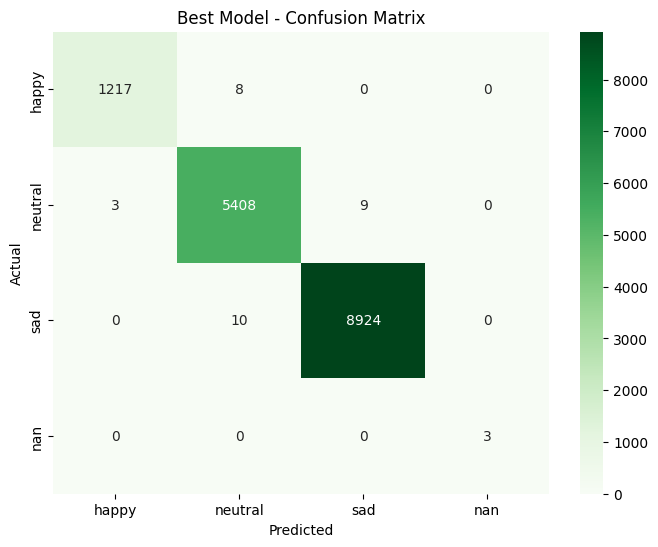

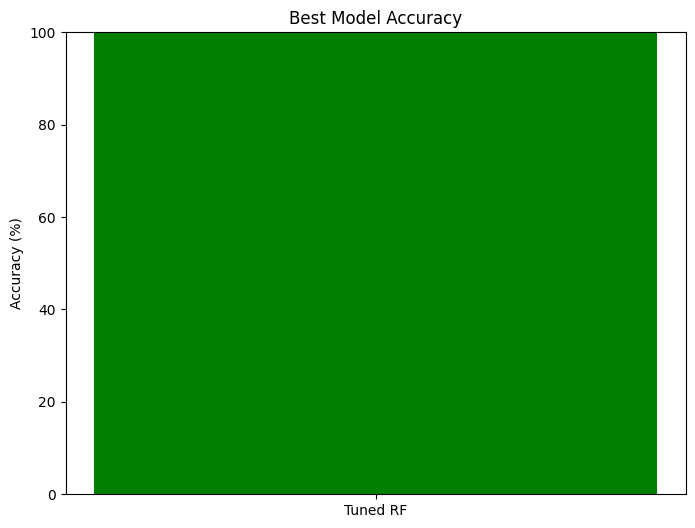

<ipython-input-4-146dc2b910fc>:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette=['blue', 'green'])


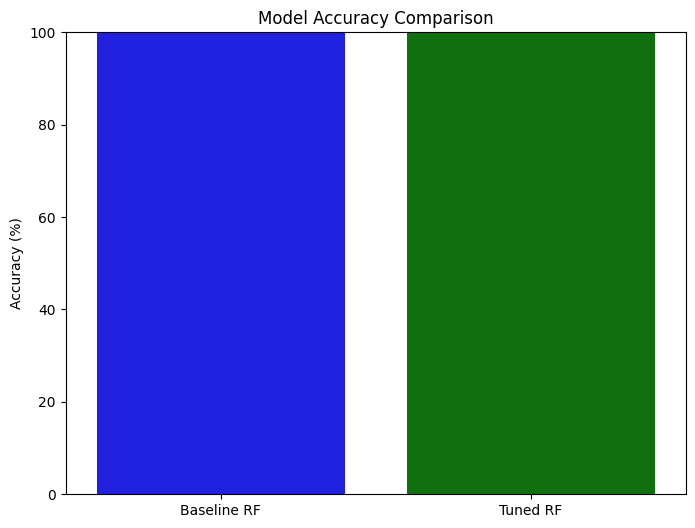

In [ ]:
# ------------------------------
# Part 4: Model Implementation and Evaluation
# ------------------------------

# Load the processed dataset again (to ensure we work with the cleaned data).
file_path_processed = "/content/dataset - Copy.csv"  # Update path if needed
df = pd.read_csv(file_path_processed)

# ------------------------------
# Create the target variable.
# ------------------------------
# If a "mood" column does not exist, create one using a simple rule—here based on the product of 'valence' and 'energy'.
if 'mood' not in df.columns:
    df['mood'] = pd.cut(df['valence'] * df['energy'],
                        bins=[0, 0.33, 0.66, 1],
                        labels=['sad', 'neutral', 'happy'])

# Define the input features and target variable.
features = ['tempo', 'loudness', 'valence', 'danceability', 'energy', 'acousticness']
X = df[features]
y = df['mood']

# Encode the target as numeric labels.
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ------------------------------
# Feature Selection: Optionally select the top 4 features using SelectKBest.
# ------------------------------
selector = SelectKBest(f_classif, k=4)
X_selected = selector.fit_transform(X, y_encoded)
selected_features = X.columns[selector.get_support()].tolist()
print("Selected features:", selected_features)

# ------------------------------
# Split the dataset into training and test sets.
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_encoded, test_size=0.2, random_state=42)

# ------------------------------
# Baseline Model Evaluation
# ------------------------------

# Train a baseline Random Forest model with default hyperparameters.
baseline_rf = RandomForestClassifier(n_estimators=100, random_state=42)
baseline_rf.fit(X_train, y_train)

# Predict on the test set.
y_pred_baseline = baseline_rf.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"\nBaseline Model Accuracy: {baseline_accuracy * 100:.2f}%\n")
print("Baseline Classification Report:")
print(classification_report(y_test, y_pred_baseline, target_names=le.classes_.astype(str)))

# Plot the confusion matrix for the baseline model.
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_.astype(str),
            yticklabels=le.classes_.astype(str))
plt.title('Baseline Model - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot the baseline model accuracy.
plt.figure(figsize=(8, 6))
plt.bar(['Baseline RF'], [baseline_accuracy * 100], color='blue')
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.title('Baseline Model Accuracy')
plt.show()

# ------------------------------
# Hyperparameter Tuning with GridSearchCV
# ------------------------------

# Define a grid of parameters to search over.
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV with 5-fold cross-validation.
grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Retrieve the best model from the grid search and its parameters.
best_rf = grid_search.best_estimator_
print("Best Hyperparameters from GridSearchCV:")
print(grid_search.best_params_)
print(f"Best Cross-Validated Accuracy: {grid_search.best_score_ * 100:.2f}%")

# Evaluate the best model on the test set.
y_pred_best = best_rf.predict(X_test)
best_accuracy = accuracy_score(y_test, y_pred_best)
print(f"\nBest Model Test Accuracy: {best_accuracy * 100:.2f}%\n")
print("Best Model Classification Report:")
print(classification_report(y_test, y_pred_best, target_names=le.classes_.astype(str)))

# Plot the confusion matrix for the tuned model.
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_.astype(str),
            yticklabels=le.classes_.astype(str))
plt.title('Best Model - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot the accuracy of the best model.
plt.figure(figsize=(8, 6))
plt.bar(['Tuned RF'], [best_accuracy * 100], color='green')
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.title('Best Model Accuracy')
plt.show()

# ------------------------------
# Comparative Plot of Baseline vs. Best Model
# ------------------------------
plt.figure(figsize=(8, 6))
models = ['Baseline RF', 'Tuned RF']
accuracies = [baseline_accuracy * 100, best_accuracy * 100]
sns.barplot(x=models, y=accuracies, palette=['blue', 'green'])
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.show()
